# Main working file

In [10]:
# imports

## system
import os
import numpy as np
import pandas as pd

import util.feature_selection as fs
import util.correlation_measure as cm

LOCATION = "data"
ACTION_UNITS = "data/au"
FEATURE_FOLDER = "features"
CORRELATION_FOLDER = 'correlations'
PHASES = [f'{name}_{i}' for name, num in  [("instructional_video", 1), ("discussion_phase", 2), ('reschu_run',8)] for i in range(num)]#, ("reschu_run", 8)] for i in range(num)]
SETS = ['corrca', 'factors']
FACTORS = ['f1', 'f2', 'f3', 'f4', 'f5', 'f6']
COMPONENTS = ['c1', 'c2', 'c3']
PAIRS = [f'0{i}_0{i+1}' for i in np.arange(1,9,2)]
PAIRS.append("09_10")
PAIRS.extend([f'{i}_{i+1}' for i in np.arange(11,104,2)])


AVAILABLE_PAIRS = []
SKIP_PAIRS = ['53_54', '55_56', "63_64", "89_90"]
for file in os.listdir(ACTION_UNITS):
    if ".csv" in file and 'Data' in file: 
        filename = os.path.join(ACTION_UNITS, file)
        participant, _ = file.split("_",1)
        participant = participant[2:]
        for p in PAIRS:
            p1,p2 = p.split("_")
            if participant == p1 or participant == p2:
                pair = p
                break
        if pair in SKIP_PAIRS:
            continue
        if pair not in AVAILABLE_PAIRS:
            AVAILABLE_PAIRS.append(pair)
            dir = os.path.join(LOCATION, pair)
            os.makedirs(dir, exist_ok=True)
            dir = os.path.join(LOCATION, pair, FEATURE_FOLDER)
            os.makedirs(dir, exist_ok=True)
            dir = os.path.join(LOCATION, pair, CORRELATION_FOLDER)
            os.makedirs(dir, exist_ok=True)

print(len(AVAILABLE_PAIRS))


44


# Feature selection


## Corrca Weights

In [2]:
## CREATING WEIGHTS FOR EACH PAIR SEPARATELY

# corrCA takes a df as input. This df should be all files for a pair. 
for pair in AVAILABLE_PAIRS:
    print(pair)
    weights_path = os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv')
    if os.path.exists(weights_path):
        print(f"Already computed corrca weights for {pair}, skipping...")
        continue

    p1, p2 = pair.split("_")
    p1_df = pd.DataFrame()
    p2_df = pd.DataFrame()

    for file in os.listdir(ACTION_UNITS):
        if '.csv' in file and 'Data' in file and p1 in file: 
            df = pd.read_csv(os.path.join(ACTION_UNITS, file))
            p1_df = pd.concat([p1_df, df])
        if '.csv' in file and 'Data' in file and p2 in file: 
            df = pd.read_csv(os.path.join(ACTION_UNITS, file))
            p2_df = pd.concat([p2_df, df])
    if len(p1_df) < 1 or len(p2_df) < 1:
        print(f"Pair {pair} misses either navigator or pilot action unit files, REMOVING FROM AVAILABLE PAIRS...")
        AVAILABLE_PAIRS = [i for i in AVAILABLE_PAIRS if i!=pair]
        continue
    p1_df = p1_df.iloc[:len(p2_df)]
    p2_df = p2_df.iloc[:len(p1_df)]

    mask = (p1_df.isna().any(axis=1).values) | (p2_df.isna().any(axis=1).values)
    p1_df = p1_df[~mask].reset_index(drop=True)
    p2_df = p2_df[~mask].reset_index(drop=True)
    w = fs.corrCA_weights(p1_df, p2_df) #output = pair/pair_corrca_weights.csv
    w.to_csv(os.path.join(LOCATION, pair, f"{pair}_corrca_weights.csv"), index=False)

print(len(AVAILABLE_PAIRS))

05_06
Already computed corrca weights for 05_06, skipping...
07_08
Already computed corrca weights for 07_08, skipping...
09_10
Already computed corrca weights for 09_10, skipping...
99_100
(17, 17)
101_102
(17, 17)
103_104
Already computed corrca weights for 103_104, skipping...
13_14
(17, 17)
15_16
Pair 15_16 misses either navigator or pilot action unit files, REMOVING FROM AVAILABLE PAIRS...
17_18
(17, 17)
19_20
(17, 17)
21_22
(17, 17)
23_24
Pair 23_24 misses either navigator or pilot action unit files, REMOVING FROM AVAILABLE PAIRS...
25_26
(17, 17)
27_28
Already computed corrca weights for 27_28, skipping...
29_30
(17, 17)
31_32
(17, 17)
33_34
(17, 17)
35_36
(17, 17)
37_38
(17, 17)
39_40
(17, 17)
41_42
(17, 17)
43_44
(17, 17)
45_46
(17, 17)
47_48
(17, 17)
49_50
(17, 17)
51_52
(17, 17)
59_60
(17, 17)
61_62
(17, 17)
65_66
(17, 17)
67_68
(17, 17)
69_70
(17, 17)
71_72
(17, 17)
73_74
(17, 17)
75_76
(17, 17)
77_78
(17, 17)
79_80
(17, 17)
81_82
(17, 17)
83_84
Already computed corrca weig

In [5]:
print(AVAILABLE_PAIRS)

['05_06', '07_08', '09_10', '99_100', '101_102', '103_104', '13_14', '17_18', '19_20', '21_22', '25_26', '27_28', '29_30', '31_32', '33_34', '35_36', '37_38', '39_40', '41_42', '43_44', '45_46', '47_48', '49_50', '51_52', '59_60', '61_62', '65_66', '67_68', '69_70', '71_72', '73_74', '75_76', '77_78', '79_80', '81_82', '83_84', '85_86', '87_88', '91_92', '93_94', '95_96', '97_98']


## Feature extraction: Factors and CorrCA

In [3]:
## EXTRACTING FACIAL FACTORS AND CORRCA FOR EACH FILE SEPARATELY
for pair in AVAILABLE_PAIRS:
    # check whether we can perform corrca
    if not os.path.exists(os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv')):
        print(f"Found no corrca weights for {pair}")    
    else:
        w = pd.read_csv(os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv'))

    p1, p2 = pair.split("_")
    for phase in PHASES: 
        p1_file = os.path.join(ACTION_UNITS, f"pp{p1}_navigator_{phase}_AU_withMissingData.csv")
        p2_file = os.path.join(ACTION_UNITS, f"pp{p2}_pilot_{phase}_AU_withMissingData.csv")

        if os.path.exists(p1_file) and os.path.exists(p2_file):
            p1_df = pd.read_csv(p1_file)
            p2_df = pd.read_csv(p2_file)

            # make equal length
            p1_df = p1_df.iloc[:len(p2_df)]
            p2_df = p2_df.iloc[:len(p1_df)]

            # remove all missing data
            mask = (p1_df.isna().any(axis=1).values) | (p2_df.isna().any(axis=1).values)
            p1_df = p1_df[~mask].reset_index(drop=True)
            p2_df = p2_df[~mask].reset_index(drop=True)

            p1_factors = fs.au_to_factors(p1_df)
            p1_factors.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p1}_{phase}_factors.csv"), index=False)
            
            p2_factors = fs.au_to_factors(p2_df)
            p2_factors.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p2}_{phase}_factors.csv"), index=False)

            if not os.path.exists(os.path.join(LOCATION, pair, f'{pair}_corrca_weights.csv')):
                continue

            p1_corrca = fs.apply_corrCA_weights(p1_df, w)
            p1_corrca.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p1}_{phase}_corrca.csv"), index=False)

            p2_corrca = fs.apply_corrCA_weights(p2_df, w)
            p2_corrca.to_csv(os.path.join(LOCATION, pair, FEATURE_FOLDER, f"pp{p2}_{phase}_corrca.csv"), index=False)
            



# Correlation measure: cRQA

In [32]:
import random
# TODO: RR overall for TP correlation
# TODO: max lag analysis for phase analysis


# chosen radii that work to get meaningful results: real pairs are still captured and fake pairs are not
RADIUS = {
    'f1': 0.1,
    'f2': 0.3, # excl?
    'f3': 0.15,
    'f4': 0.1,
    'f5': 0.2,
    'f6': 0.15,
    'c1': 0.15,
    'c2': 0.15,
    'c3': 0.20 
}

REMOVE_NEM = {
    'f1': 0,
    'f2': 1,
    'f3': 1,
    'f4': 1,
    'f5': 0,
    'f6': 1,
    'c1': 1,
    'c2': 1,
    'c3': 1 
}

RESCHU_DATA = {}
for pair in AVAILABLE_PAIRS:
    p1, _ = pair.split("_")
    RESCHU_DATA[pair] = {
        'score' : random.randint(1,25),
        'zoom'  : (int(p1)-1)%4 < 2,
        'beeps' : [int(p1) % 4 == 1, int(p1) % 4 != 1] * 4
    }



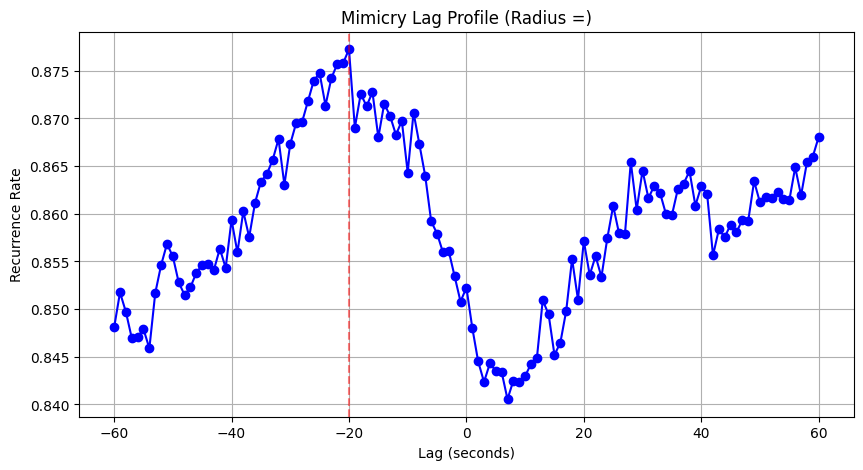

In [29]:
import matplotlib.pyplot as plt
nav = pd.read_csv('data/05_06/features/pp05_reschu_run_1_factors.csv')
pil = pd.read_csv('data/05_06/features/pp06_reschu_run_1_factors.csv')

output = cm.crqa_lag_analysis(nav['f1'].values, pil['f1'].values)
lags = np.arange(-60,61)
rr_profile = output['rr_profile']
plt.figure(figsize=(10, 5))
plt.plot(lags, rr_profile, 'b-o')
plt.axvline(lags[np.argmax(np.array(rr_profile))], color='r', linestyle='--', alpha=0.5)
plt.xlabel('Lag (seconds)')
plt.ylabel('Recurrence Rate')
plt.title(f'Mimicry Lag Profile (Radius =)')
plt.grid(True)
plt.show()


In [ ]:
for pair in AVAILABLE_PAIRS:
    print(f'{pair} is being processed')
    # if os.path.exists(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_overall.csv')):
    #     continue
    p1, p2 = pair.split("_")
    RR_overall = pd.DataFrame(columns=['phase', *FACTORS, *COMPONENTS])
    RR_profile = pd.DataFrame(columns=['phase', 'component' *np.arange(-60,61)])
    files = os.path.join(LOCATION, pair, FEATURE_FOLDER)
    for phase in PHASES:
        nav_file = os.path.join(files,f'pp{p1}_{phase}_corrca.csv')
        pil_file = os.path.join(files,f'pp{p2}_{phase}_corrca.csv')


        # for RR
        components = []
        if os.path.exists(nav_file) and os.path.exists(pil_file):
            for c in COMPONENTS:
                nav = pd.read_csv(nav_file)
                pil = pd.read_csv(pil_file)
                corr = cm.crqa_lag_analysis(nav[c].values, pil[c].values)
                components.append(corr['RR'])
                RR_profile.loc[len(RR_profile)] = [phase, c, *corr['rr_profile']]

            # We assume that the corrca component features cannot be extracted without the factor features also being extracted. 
            nav_file = os.path.join(files,f'pp{p1}_{phase}_factors.csv')
            pil_file = os.path.join(files,f'pp{p2}_{phase}_factors.csv')

        
            for f in FACTORS:
                nav = pd.read_csv(nav_file)
                pil = pd.read_csv(pil_file)
                fac = cm.crqa_lag_analysis(nav[f].values, pil[f].values)
                components.append(fac['RR'])
                RR_profile.loc[len(RR_profile)] = [phase, f, *corr['rr_profile']]

            RR_overall.loc[len(RR_overall)] = [phase, *components]
    RR_overall.to_csv(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_overall.csv'), index=False)
    RR_profile.to_csv(os.path.join(LOCATION, pair, CORRELATION_FOLDER, f'{pair}_rr_profile.csv'), index=False)


05_06 is being processed
07_08 is being processed
09_10 is being processed


KeyboardInterrupt: 

# EXPERIMENT AREA

In [ ]:
df = pd.DataFrame(columns = ['1', '2','3', '4'])



In [42]:
row = [1,2,3]
df.loc[len(df)] = [1, *row]
df

,1,2,3,4
0,1,2,3,5
1,1,2,3,5
2,1,2,3,5
3,1,2,3,5
4,1,2,3,5
5,1,1,2,3
